P3 Behavioral Cloning Project
===================
**Author:  Myles Iribarne**

1. Introduction
-----------------
This project trains a neural network to automatically generate steering commands for a simulated car driving around a track. The simulator can be found here: https://d17h27t6h515a5.cloudfront.net/topher/2017/February/58983558_beta-simulator-linux/beta-simulator-linux.zip

When in recording mode, the simulator records an image from the perspective of the camera placed on the car along with the steering and throttle commands. In this mode, the car is driven manually using the keyboard and mouse as inputs for the throttle and steering.

When in autonomous mode, the steering commands are generated automatically by the trained neural network and the throttle is assumed to be constant. 

2. Training Data
----------------------
There are two tracks provided by the simulator. The first was used to generate the training data. The second is used as a challenge test set to see how well the simulator performs on a track that it has never seen.
Some of the training data was provided by udacity as a resource to begin training data. The rest of the data was generated by manually driving the car around the track trying to stay centered on the track. Approximately 2 laps were made around the track in addition to the data provided by udacity. 

Since most of the unmodified training data remained centered on the track (good driving), the network may never be robust to recovering from being off-center or pointing incorrectly. In order to make the network more robust, two approaches were taken: 

1) Left, Right and Center Cameras: 

2) Data Augmentation

These are explained in further detail in the next two sections

2.1 Using Left, Right and Center Cameras:
-------------------------------------
In one version of the simulator, the simulated car is outfitted with three cameras: one on the left side of the car, one in the center of the car, and the third on the right side of the car. The left and right camera images can be used to provide robustness to the training data. The steering parameter recorded during each timestep corresponds to the steering angle corresponding to the center camera. To simulate what the steering command would have been if the car had been centered on the left or right cameras, small "corrections" to the steering command are added or subtracted. This is similar to the techinque used by NVDIA in this paper:
http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

NOTE: This is implemented by the "grab_steering()" function defined in model.py. The hyperparameter to tune this is "camera_shift_val" which defines how much the steering is adjusted for the left and right cameras. Hyperparameter: camera_shift_val = 0.1)




Using TensorFlow backend.
/home/myles-iribarne/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Model Compiled...



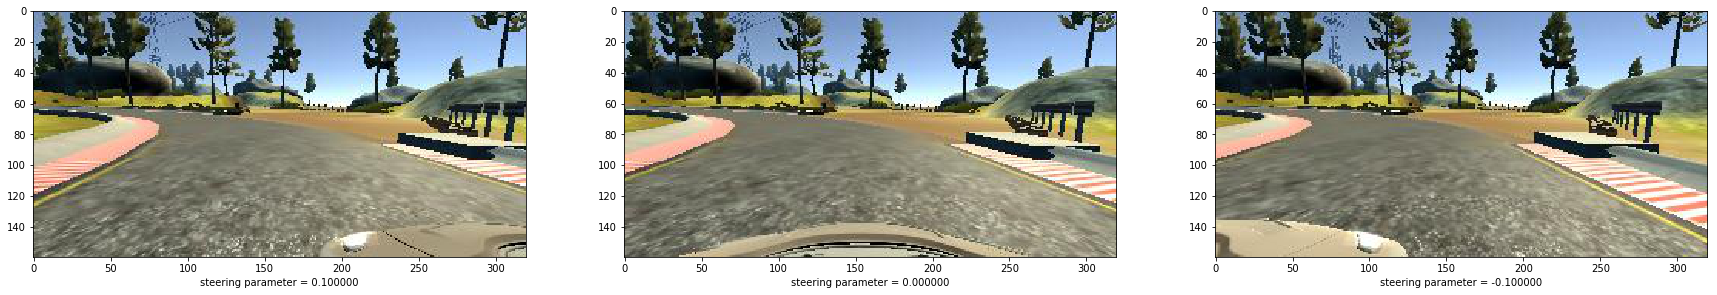

In [1]:
exec(open("./data_augmentation.py").read())
exec(open("./model.py").read())
import matplotlib.pyplot as plt
%matplotlib inline
idx = 5
camera = 0
image_left, steering_left = grab_data(csv_data,idx,0)
image_center, steering_center = grab_data(csv_data,idx,1)
image_right, steering_right= grab_data(csv_data,idx,2)

def plot_data(img,steering):
    plt.imshow(img.squeeze().astype('uint8'))
    plt.xlabel("steering parameter = %f" % steering)

plt.figure(figsize=(30,30))
plt.subplot(1,3,1)
plot_data(image_left, steering_left)

plt.subplot(1,3,2)
plot_data(image_center, steering_center)

plt.subplot(1,3,3)
plot_data(image_right, steering_right)

2.2 Data Augmentation
----------------
The other approach used to add robustness to the network is data augmentation. This technique modifies the images and steeering commands to simulate different environments that are not directly represented by the training data. The following data augmentation techinques were used. Many of these were inspired by an excellent blog post by Vivek Yadav which can be found here:
https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.5msrgw4jj


- Horizontal shifts to the images: These represent small variations to the position of the car in the lane line. Small corrections to the steering angle are added proportional to the number of pixels shifted to simulate small steering angle corrections to stay centered on the road. This is similar to the idea presented in the "Using Left, Right and Center Cameras" section. (Hyperparameter: steering_per_pixel = 0.003),(Hyperparameter: trans_range = (15,30) # (y,x) translation ranges)


- Vertical shifts to the images: This is used to simulate the car going up or down a hill to make the neural network robust to this variation (Hyperparameter: trans_range = (15,30) # (y,x) translation ranges)


- Vertical mirror images: This simulates the car turning right where in the un-augmented training image it was turning left. The steering angle is negated (multiplied by negative one) to simulate what the steering command would have been in this situation. This generates new data for the network to train on and also ensures that the network does not have a bias toward left or right turns. (Hyperparameter: vflip_prob = 0.5)


- Image brightness: The image brightness is augmented to simulate driving conditions under varying lights. The steering command is not touched in this augmentation. This augmentation is accomplished by converting the images to an hsv (hue, saturation, value) color channels and multiplying the value channel by a random scalar. Care must be taken to the value saturates and does not roll over which causes random darkspots in the image. The steering is not modified in this augmentation. (Hyperparameter: brightness_range = (0.25,1.25))


- Add random shadows: This data augmentation adds random shadows to the image by making a random portion of the image darker. (Hyperparameter: add_shadow = True) (Hyperparameter: shadow_intensity = 0.4)


All of these data augmentation techniques, and others, are implemented in data_augmentation.py. Each of these data augmentations can be applied individually with calls to each data augmentation function, or all together like this:

 image, AugImg_Values = augment_image(image, shear_range = (0,0), rot_range =(0,0),
                                            vflip_prob = vflip_prob, hflip_prob = 0, add_shadow = add_shadow, shadow_intensity = shadow_intensity,
                                            trans_range = trans_range, brightness_range = brightness_range, return_rand_param = True)
                                            

In order to make this data augmentation portable to other projects, I created a seperate .py file that contains all of the code called data_augmentation.py



The AugImg_Values returns the result of random application with the indicated parameters so that the label data (steering in this case) can be modified appropriately.

Taking a random image and applying random combinations of these data augmentations results in these images show below.

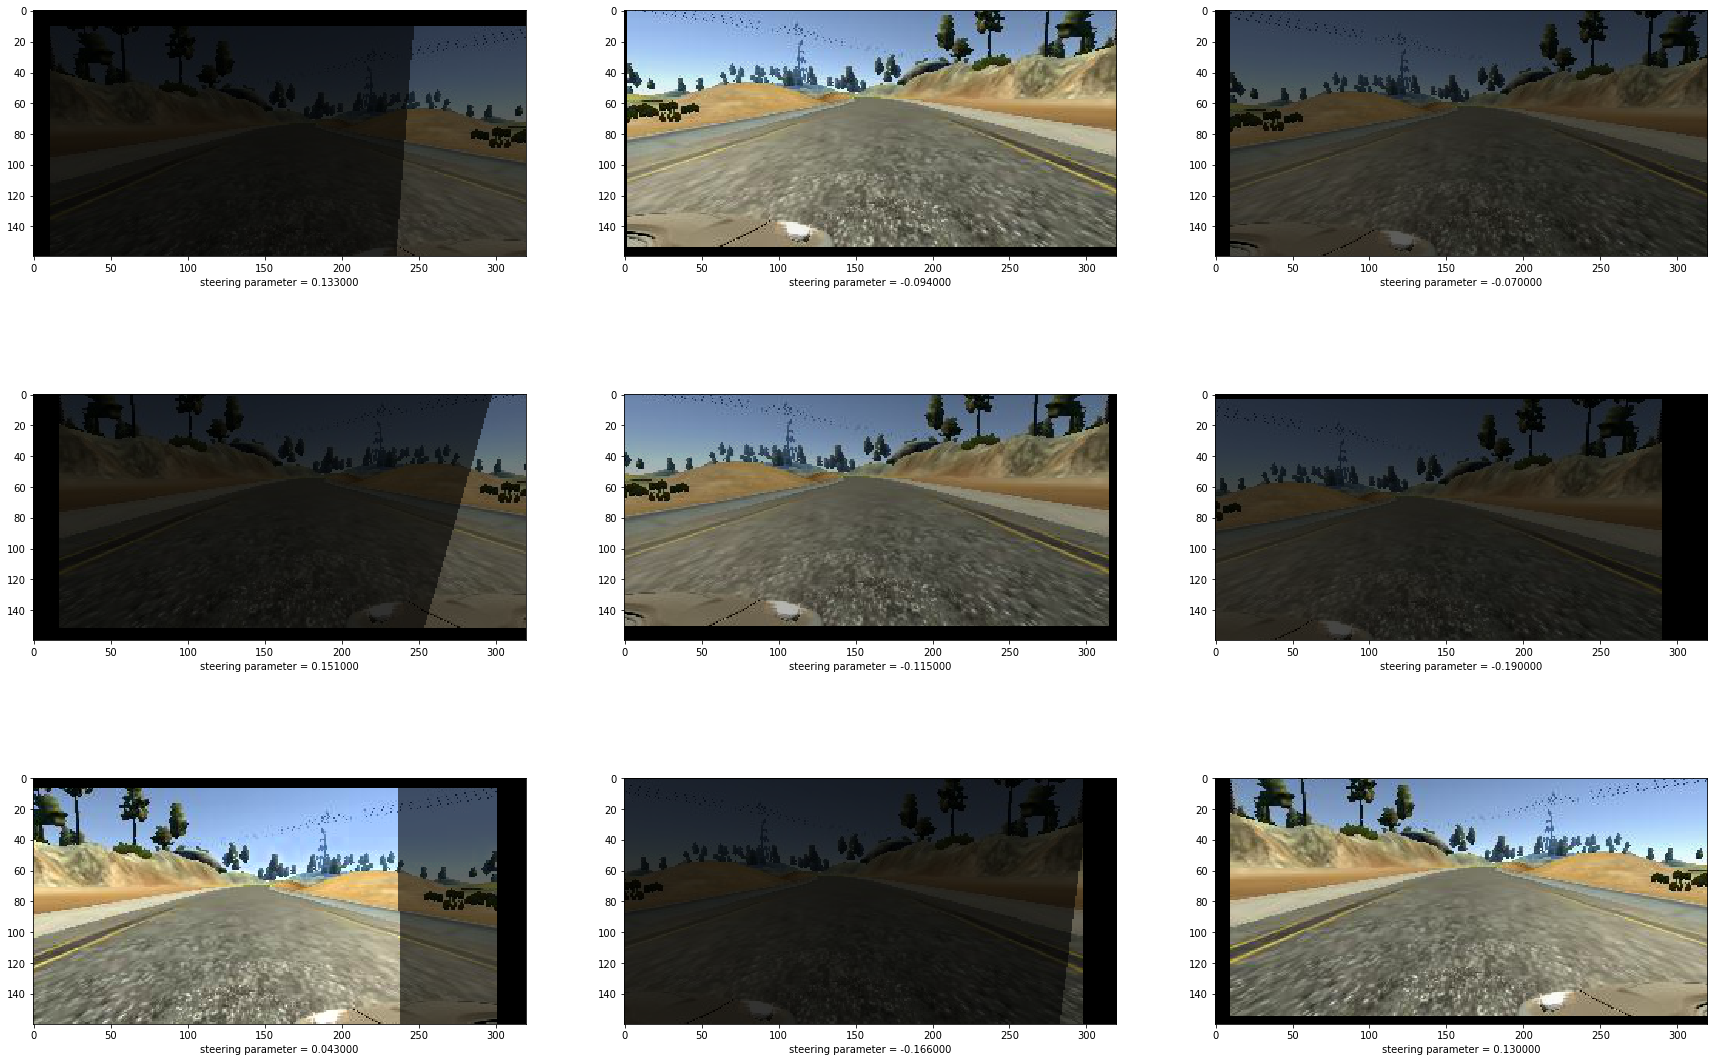

In [2]:
idx = 400
image, steering_cmd = grab_data(csv_data,idx,0)

n = 3
plt.figure(figsize=(30,20))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    image_A, steering_cmd_A  =augment_data(image, steering_cmd)
    plot_data(image_A,steering_cmd_A)
plt.show()

3. Data pre-processing
---------------------
After data augmentation has been applied but before the image is introduced to the neural network, data pre-processing is computed on each image. This is composed of three steps:

    1) Cropping the image to remove 30 pixels from the top to remove the sky portion of the image, and 25 pixels from the bottom to remove the car hood. Both of these are not relevant to the problem of computing the steering angle
    
    2) Re-sizing the image to (66,200,3) to match the shape of the NVIDIA images to be able to leverage the architecture they used. This is accomplished with the cv2 function "resize": 
    image = cv2.resize(image,(input_shape[1],input_shape[0]),interpolation=cv2.INTER_AREA)
    
    3) Normalizing the image so each image is between -0.5 and 0.5. This is accomplished using the keras  "Lambda" layers like this: 
    model.add(Lambda( lambda x: x/255.0-0.5, input_shape = input_shape))

4. Data generators
---------------------
In order to reduce the memory requirements for training, I created a python generator that produces batches of images at a time instead of loading the whole training dataset. This generator randomly selects the images, applies the data augmentation described in section 2.2, and applies the preprocessing described in section 3. In addition, the rejects data with a probability inversely proportional to its average occurance in the dataset. 

To explain this last point further, I plot a histogram of the occurance of different steering commands generated by randomly sampling 10000 datum:

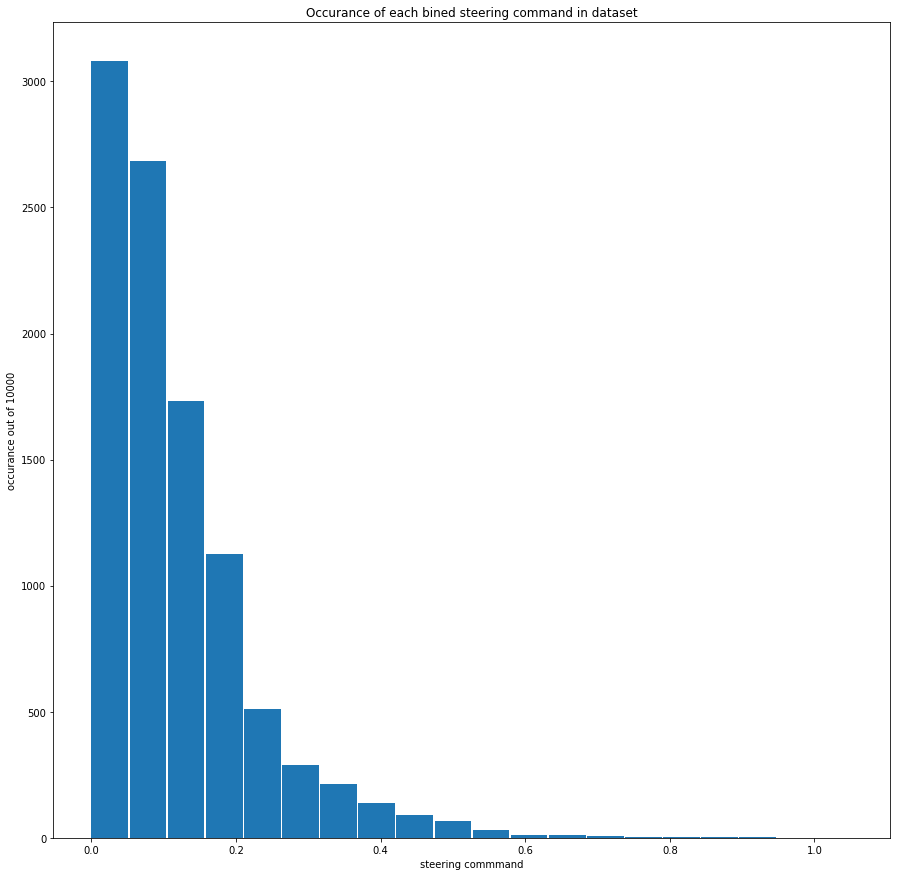

In [3]:
n = 10000
bins = 20
random_idx_gen = pick_random_image_idx(csv_data)
steering_rand = np.zeros(n)
for i in range(n):
    row, camera = next(random_idx_gen)
    steering_cmd = grab_steering(csv_data, row, camera)
    # emulate data augmentation
    tr_x = np.random.randint(-trans_range[1],trans_range[1]+1)
    steering_cmd = steering_cmd + steering_per_pixel*tr_x
    flip_image = np.random.uniform()<vflip_prob
    if flip_image:
        steering_cmd = -steering_cmd
    steering_rand[i] = steering_cmd

#estimate keep probability for bin'ed data to equalize training occurance of each label
(bins_n, bin_edges) = np.histogram(abs(steering_rand),bins) 

plt.figure(figsize=(15,15))
width = bin_edges[1]-bin_edges[0]-.002
plt.bar(bin_edges[0:-1]+width/2,bins_n, width = width)
plt.xlabel('steering commmand')
plt.ylabel('occurance out of 10000')

plt.title('Occurance of each bin''ed steering command in dataset')

As you can see, the occurance of very steering commands vastly outnumbers the occurance of larger steering commands. This alone would bias the network toward chosing small steering commands in order to reduce the global error. In order to avoid this bias, the generator is designed to randomly reject data that has a steering command in each of the above bins with a keep probabilitiy inversely proportional to the occurance. The probability of keeping a steering command in each bin is shown here:

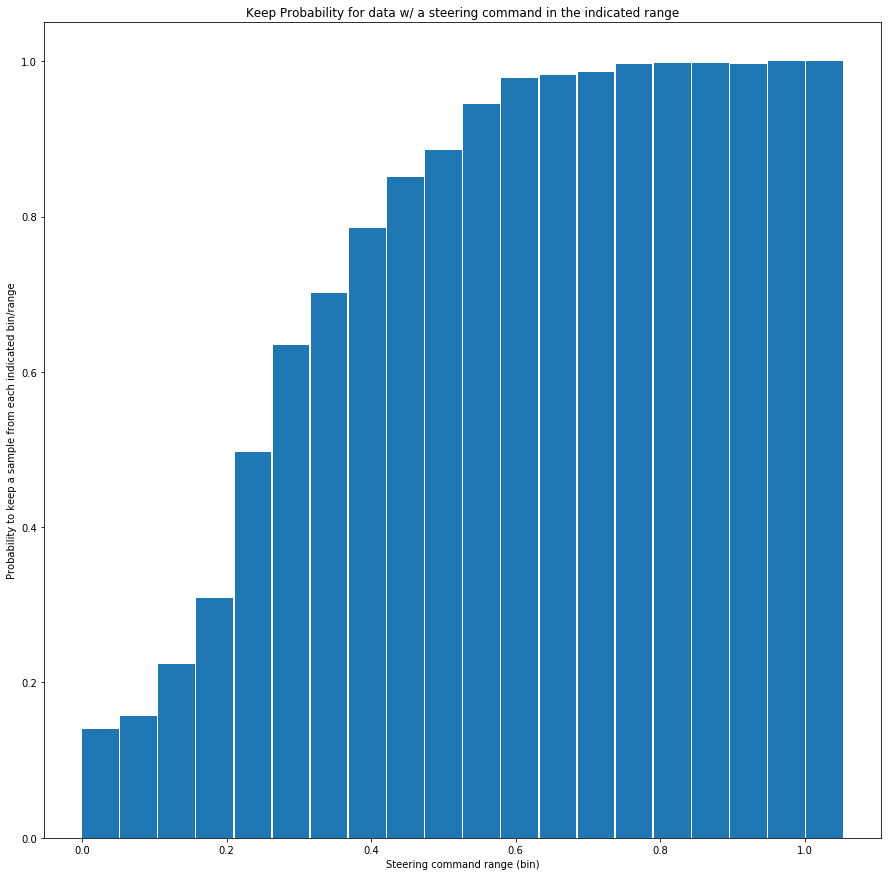

In [4]:
bins_n = bins_n+500 #add constant to smooth over and avoid divide by zero
bins_n_normalized = bins_n/sum(bins_n)
bins_n_keep_ratio = 1/bins_n_normalized
bins_n_keep_prob  = bins_n_keep_ratio/max(bins_n_keep_ratio)

plt.figure(figsize=(15,15))
plt.bar(bin_edges[0:-1]+width/2,bins_n_keep_prob, width = width)
plt.title('Keep Probability for data w/ a steering command in the indicated range')
plt.xlabel('Steering command range (bin)')
plt.ylabel('Probability to keep a sample from each indicated bin/range')

5. Convolutional Neural Network Architecture
------------------------------------

The neural network chosen closely follows the architecture presented in the following paper by NVIDIA:
http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

The network contains 5 convolutional layers of various sizes and strides are followed by 4 fully connected layers. In all cases, the relu activation function is used to introduce non-linearities to the model. Dropout with a keep dropout rate of 0.5 is added to the 3,4 and 5 convolutional layers and the first fully connected layer as a method to reduce overfitting. The total number of parameters is 252,219. The details of each layer are listed here:

**Layer 1: **

**Convolutional.** 5x5x24 with a stride of (2,2)

**Activation.** ReLU

******************************

**Layer 2: **

**Convolutional.** 5x5x36 with a stride of (2,2)

**Activation.** ReLU

******************************

**Layer 3: **

**Convolutional.** 5x5x48 with a stride of (2,2)

**Dropout.** Keep_Prob = 0.5

**Activation.** ReLU

******************************

**Layer 4: **

**Convolutional.** 3x3x64 with a stride of (1,1)

**Dropout.** Keep_Prob = 0.5

**Activation.** ReLU

******************************

**Layer 5: **

**Convolutional.** 3x3x64 with a stride of (1,1)

**Dropout.** Keep_Prob = 0.5

**Activation.** ReLU

******************************

**Layer 6: **

**Flatten **

**Fully Connected** 100 outputs

**Activation.** ReLU

**Dropout.** Keep_Prob = 0.5

******************************

**Layer 7: **

**Fully Connected** 50 outputs

**Activation.** ReLU

******************************

**Layer 8: **

**Fully Connected** 10 outputs

**Activation.** ReLU

******************************

**Layer 10: **

**Fully Connected** 1 output (steering command)

**Activation.** ReLU

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       activation_1[0][0]               
___________________________________________________________________________________________

6. Training the network
---------------------------
**6.1** Cost function

The mean-squared error cost function is chose to heavily penalize large excursions from the training data.

**6.2** Optimizer

The Adam optimizer is chosen here because it is a robust optimizer that gives good results out of the box, allowing for more concentration on other aspects of the behavioral cloning project

**6.3** Training and Validation data

In order to have a measure of how well the network is able to generalize to problems it has not seen, the 20% of the training data was reserved as validation data and this validation data was not used in training. The python generator explicitly rejects data that are in the validation set

**6.4** Training Hyperparameters

The following hyperparamters are chosen through trial and error to increase the accuracy of the neural network without overfitting. 

learning_rate = 0.001

nb_epoch = 4

samples_per_epoch = 20000

batch_size = 128

dropout = 0.5 # percent that will dropout

**6.4** How to train the model

In order to train the model, simply run the following two commands. The generator assumes that the first 8036 rows of data in the driving_log.csv contain left, center, and right images, while the remaining rows only contain center images:

exec(open("./model.py").read())

train(4,20000,load_data=False) # 4 epochs, 20000 data/epoch, load_data=False start w/random weights instead of loading exsisting weights


7. Conclusions
----------------
With the indicated data augmentation, pre-processing, equalizing steering occurance, neural network architecture, and training strategy, the network is able to succesfully drive around the track without wandering onto undrivable surfaces. In fact, the network is able to generalize and succesfully drive around the originally provided mountain theme at the "fastest" data quality without having seen a single image from this track. However, once shadows are added, the network does struggle to generalize and is unable to drive around the track. The network also has trouble generalizing to the new mountain theme and is unable to drive around the track



8. Future Work
----------------
In order to further improve on the network, there are numerous things I would like to try:
1) Increase the training efficiency and generalizing ability by applying batch normalization:
https://arxiv.org/pdf/1502.03167v3.pdf
http://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

2) Train the network with high quality training data including specifically "recovery" scenarios where the training data records the car recovering from driving on the edge of the road back to the center

3) Add  L2 normalization to reduce overfitting

4) Try more network architectures 

5) Attempt to transform the image to different color models such as hsv or black and white

6) Attempt feeding the network other useful information such as the car speed, throttle, or previous steering values to smooth the steering


I would also like to attempt to train the network on the other tracks, even if I need to use training data formt eh track itself to be succesful.
